# Plant Pathology 2020 - FGVC7

## Description
Plant Pathology 2020 - FGVC7 est une compétition Kaggle, débutée le 9 Mars 2020 et terminée le 26 Mai 2020.
L'objectif de cette compétition est d'aider à faire progresser l'apprentissage machine à partir de de ce sujet d'étude.

## Problématique
Les erreurs de diagnostic de plusieurs maladies liées aux cultures agricoles peuvent mener à une mauvaise utilisation de
produits chimiques. Cela entraine l'émergence de souches pathogènes résistantes, augmentant par la suite les coûts de production
agricoles et un impact significatif sur l'économie et l'environnement.

Est-il possible à partir d'un jeu de données de photos de cultures agricoles, déterminer l'état de santé des pousses afin de faciliter le traitement de ces dernières ?

## Jeu de données

Le jeu de données de cette compétition est constitué de 3642 images de feuilles de pomme. L'objectif sera donc d'extraire ces
images sous forme de données exploitable par la machine, de les séparer en une partie liée à l'entraînement et une autre partie liée à la validation, afin de valider nos tests puis de trouver des modèles adéquats pour répondre à la problématique initiale.

La validation de notre jeu de données dans le cadre de la compétition sera également lié à un fichier `result.csv` qu'il faudra régulièrement mettre à jour lorsque nous obtiendrons
une meilleure précision globale avec un nouveau modèle.

### Aperçu du jeu de données

![A sample of the Plant Pathology 2020 dataset](https://i.imgur.com/jmEdFKq.png)
<sub>Source: https://www.kaggle.com/c/plant-pathology-2020-fgvc7</sub>

## Plan d'approche

Notre objectif, afin de comprendre au mieux quelles sont les meilleurs modèles qui vont nous permettre d'obtenir le meilleur résultat
et d'obtenir un classement convenable ainsi qu'une réponse à la problématique, sera de tester plusieurs modèles précédemment testés sur CIFAR-10.
Le but ne sera donc pas de simplement répliquer les modèles à ce jeu de données mais surtout de mettre l'accent sur pourquoi
le jeu de données produit des résultats différents et comment améliorer les modèles existants.

Dans un premier temps, nous allons nous occuper de la préparation de l'environnement, de l'import du jeu de données puis de son exploitation dans les différents modèles suivants :

- Le modèle linéaire
- Le perceptron multi-couches (PMC / MLP)
- Le convolutional neural network (ConvNet / CNN)
- Le residual neural network (Resnet)
- Le recurrent neural network (RNN)

## Préparation de l'environnement

### Pré-requis

Dans un premier temps, il faut installer [Anaconda](https://www.anaconda.com/) en local sur votre ordinateur en suivant ce [guide]((https://docs.conda.io/projects/conda/en/latest/user-guide/install/)).

Ensuite, dans le root du projet, vous devriez visualiser l'invite de commande de cette manière là:
```
(base) C:\Users\Anon\PycharmProjects\kaggle-competition>
```

Après ça, vous devez mettre en place votre [clé pour l'API Kaggle](https://github.com/Kaggle/kaggle-api#api-credentials) sur votre ordinateur.

Il est possible de directement importer le dataset localement sur sa machine via le package `kaggle` qui est automatiquement installée via l'outil de création d'environnements.

Il suffit alors de lancer à la racine du projet :

```
python -m tools.create_env kaggle-competition
conda activate kaggle-competition
kaggle competitions download -c plant-pathology-2020-fgvc7
python -m tools.extract_dataset_zip plant-pathology-2020-fgvc7
```

Ces commandes passent directement par des outils d'extraction et de traitement en Python et permettent de facilement démarrer pour passer à la création des différents modèles.
***

#### /!\ Attention
Si votre carte graphique le permet et que vous avez fait la [configuration préalable](https://www.tensorflow.org/install/gpu), il est préférable que vous passiez directement par `tensorflow-gpu` afin d'effectuer vos entraînements, il sera donc préférable que vous réinstalliez la version préférable de la manière suivante :
```
conda uninstall tensorflow
conda install tensorflow-gpu
```
***

## Importation des données

Pour l'importation des données nous avons utilisé la classe `ImageDataGenerator` proposée par TensorFlow.

In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Nous avons également utilisé par les data frames proposés par Pandas afin de les mettre comme argument dans la fonction `flow_from_dataframe()`.

In [86]:
import pandas as pd

Après import de ces librairies et création de l'environnement, nous pouvons directement récupérer les informations pour créer nos différents dataframe.

In [87]:
df = pd.read_csv("../data/plant-pathology-2020-fgvc7/train.csv") # training set list
df_test = pd.read_csv("../data/plant-pathology-2020-fgvc7/test.csv") # test set list


On ajoute ensuite `.jpg` en extension pour pouvoir directement lire les images à partir de la colonne `image_id`.

In [88]:
df['image_id'] = df['image_id'].astype(str) + ".jpg"
df_test['image_id'] = df_test['image_id'].astype(str) + ".jpg"

Par la suite, nous définissons les différentes variables que nous allons utiliser pour générer notre jeu de données de manière à ce que ce soit exploitable par notre machine.

In [89]:
batch_size = 32
img_width, img_height = 300, 300
img_dir = "../data/plant-pathology-2020-fgvc7/images"
x_col = "image_id"
y_col = ["healthy", "multiple_diseases", "rust", "scab"]

Une fois les variables initialisées, on génère les différents objets nécessaires au traitement des données.

In [90]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Données d'entraînement
train_generator = datagen.flow_from_dataframe(
    dataframe=df[:1460],
    directory=img_dir,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(img_width,img_height)
    
)

# Données de validation
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=df[1460:],
    directory=img_dir,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(img_width,img_height)
)

# Données de test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=img_dir,
    x_col=x_col,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(img_width,img_height)
)

Found 1460 validated image filenames.
Found 361 validated image filenames.
Found 1821 validated image filenames.


### Visualisation d'un échantillon

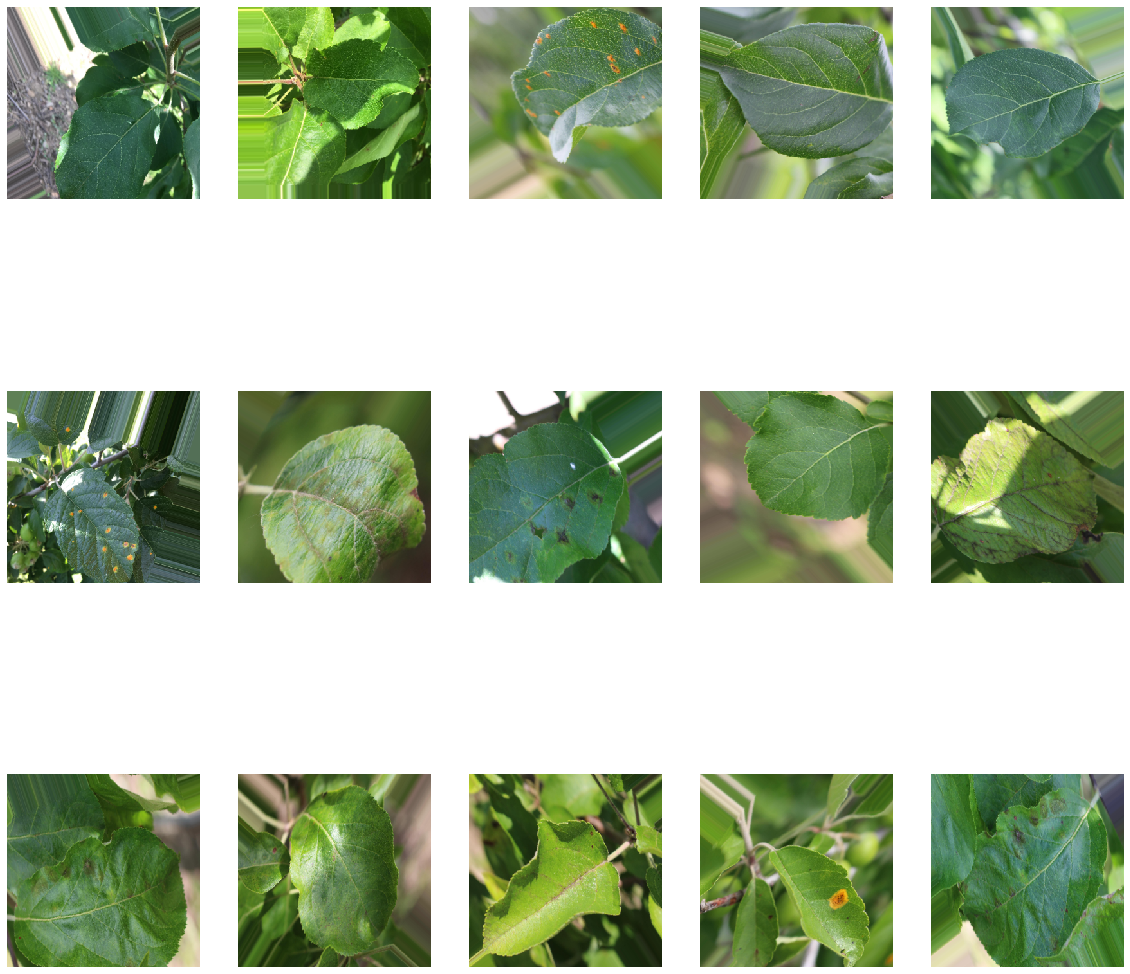

In [93]:
import matplotlib.pyplot as plt

sample_training, _ = next(train_generator)

def plot_image(images):
    fig, axes = plt.subplots(3, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images[:15], axes):
        # print(img.shape)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

plot_image(sample_training)

## Modèle Linéaire

### Introduction

![Régression linéaire](https://i.imgur.com/iBlB5oU.png)

Le modèle linéaire est basé directement sur la prédiction de chacune des images. C'est un réseau de neurones n'ayant qu'une seule couche
et n'effectuant donc pas beaucoup de calculs et de transformation de la matrice d'origine.

L'objectif du modèle linéaire n'est donc pas d'obtenir le meilleur modèle directement, mais simplement
de déterminer si celui-ci peut suffir et si il est nécessaire d'évoluer vers un modèle plus avancé.

### Création du modèle et représentation